# Model Evaluation and comparaison

In this section we will compare the two approach for uplift modelling.  
- First, we will calculate the uplift values and look at the distribution
- Then, we'll have a look at the predicted uplift compared to the customer type latent variable
- Finally we'll compare the two approchaes 
    - by looking at the uplift per decile of the population targeted
    - by comparing their qini curves 

In [149]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [150]:
import warnings
warnings.filterwarnings('ignore')
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import seaborn

# Predictions Distributions

### Two models approach

In [151]:
df = pd.read_csv("/Users/pierregutierrez/Downloads/uplift_predictions.csv")

Let's have a look at the predicted probabilities. 

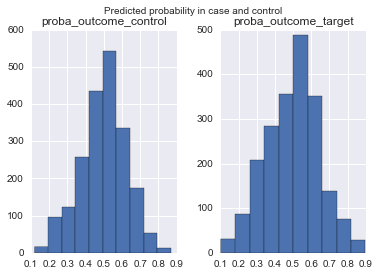

In [153]:
df[["proba_outcome_target","proba_outcome_control"]].hist()
plt.suptitle("Predicted probability in case and control")

Note that since the models are not very good, the probabilities distribution look like gaussians centered at 0.5

To calculate the uplift we just calculate the differences between the two probabilities. 

In [154]:
df["uplift_1"] = df['proba_outcome_target'] - df['proba_outcome_control']

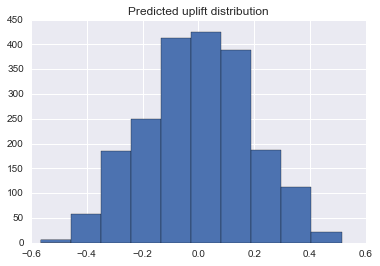

In [155]:
plt.title("Predicted uplift distribution")
df["uplift_1"].hist()

This shape is rather expected since the dataset is balanced in customer type. 

### Outcome Modification approach

To calculate the uplift, we just had to multiply by two the predicted probability and remove 1

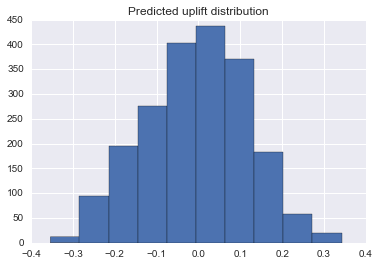

In [156]:
plt.title("Predicted uplift distribution")
df["uplift_2"].hist()

It seems rather similar to the previous distribution with bounds a bit larger. 

# Model Evaluation 

## Cutomer type based

Since this dataset was simulated, we have the true nature of people in the customer_type variable. A first way to evaluate and compare models is to look at their average predictions on each of these segments. 

A perfect model would have : 
- uplift of 1 for persuadable
- uplift of -1 for sleeping_dog
- uplift of 0 for sure_thing and lost_cause (treatment has no effect)

In [157]:
df.groupby("customer_type")[["uplift_1","uplift_2"]].mean()

,uplift_1,uplift_2
customer_type,,
lost_cause,-0.021800,-0.010683
persuadable,0.084966,0.054388
sleeping_dog,-0.097414,-0.066214
sure_thing,0.022168,-0.002540


Let's visualize this with a seaborn violin chart

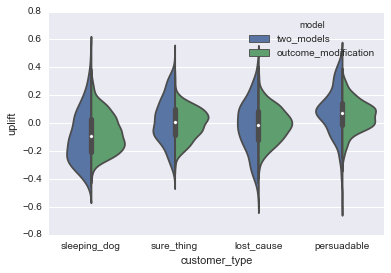

In [158]:
tmp = df[["customer_type","uplift_1"]]
tmp.columns = ["customer_type",'uplift']
tmp["model"] = "two_models"

tmp1 = df[["customer_type","uplift_2"]]
tmp1.columns = ["customer_type",'uplift']
tmp1["model"] = "outcome_modification"

tmp = pd.concat([tmp,tmp1],axis=0)

seaborn.violinplot(x="customer_type", y="uplift", hue="model", data=tmp, split = True) 
seaborn.despine(left=True)

And to get clearer ideas, a bar chart : 

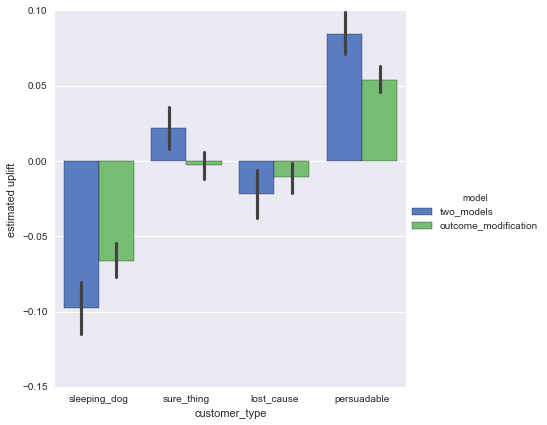

In [159]:
g = seaborn.factorplot(x="customer_type", y="uplift", hue="model", data=tmp,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("estimated uplift")

** Conclusions : ** 
- Overall the models do not seem very efficient
- by looking at the persuadable and sleeping_dog we see that the two model approach seems a bit better. 
- on the customer type on which treatment should have no effect, the outcome modification approach seems to outperform the other. 

## Uplift Evaluation

### Uplift per decile 

In this dataset, since customer types are balanced, the treatment has no global effect. But what if we were to order the population by decreasing predicted uplift ?  

From a marketing point of view, a way to evaluate uplift would be to sort the control and the treatment/target group by predicted uplift and calculate the actual uplift for bins of probability (exeample : decile)

In [160]:
df['is_target'] = df['target_control'].map(lambda x : 1 if x == 'target' else 0)
df['perfect'] = df['outcome'] * df['is_target'] -  df['outcome'] * (1-df['is_target'])

In [161]:
def get_hist(mydf, upliftcol,targetcol,outcomecol,p = 10):
    """ calucate the uplift for each decile given an uplift prediction column
    """
    control = mydf[mydf[targetcol]==0]
    target = mydf[mydf[targetcol]==1]
    control.sort(upliftcol)
    target.sort(upliftcol)
    control["percentile"] =  floor(control[upliftcol].rank(method='first',ascending = False) / (control.shape[0]+1) * p)
    target["percentile"] =  floor(target[upliftcol].rank(method='first',ascending = False) / (target.shape[0]+1) * p)
    control = (control.groupby(["percentile"])[outcomecol].mean()).reset_index()
    control.columns = ["percentile", 'prob_control']
    target = (target.groupby(["percentile"])[outcomecol].mean()).reset_index()
    target.columns = ["percentile", 'prob_target']
    final = pd.merge(control,target, on = "percentile")
    final["uplift"] = final["prob_target"] - final["prob_control"]
    return final

Let's show the observed uplift for predicted uplift bins (two models approach)

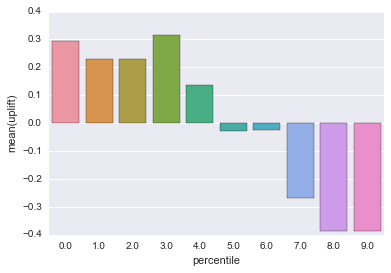

In [162]:
hist_twomod = get_hist(df, "uplift_1","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

Wow ! This is model is actually super useful ! We can reduce churn / sickness by 30 % in the first decile ! 

Let's do the same with the second approach

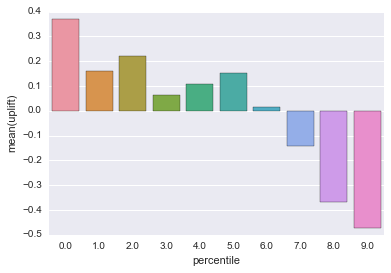

In [163]:
hist_twomod = get_hist(df, "uplift_2","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

This model seems to perform better for the first 10 % but if we look at the three first decile it does not seem to beat the first approach 

By the way... What would be the best model in our case ? We can obtain the perfect model by creating a fake uplift variable with :
- higher value on target set if outcome is 1 (converted)
- lower value on control if outcome is 1 (sure things)

This give us : 

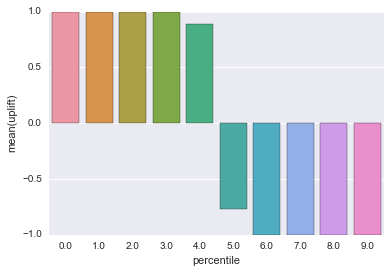

In [164]:
hist_twomod = get_hist(df, "perfect","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

We are far from it though our models have value ! 

** NB : **
- Here we sorted each dataset (target and control) and created bins on each one before calculating the difference of probability as the uplift
- an other possibility is to calculate the uplift directly for each bin after scoring the whole test.

### Cumulative uplift bins

The uplift evaluation for each bin is : RT(t)/NT(t) - RC(t)/NC(t). 
    
With : 
- RT(t) number of positive outcome and treated
- RC(t) number of positive outcome and belonging to control
- NT(t) number of treated
- NC(t) number belonging to control

In [165]:
def get_hist_cum(df, upliftcol,targetcol, outcome_col,p=10) :
    tmp = df.copy()
    tmp = tmp.sort(upliftcol,ascending=False)
    tmp["percentile"] =  floor(tmp[upliftcol].rank(method='first',ascending = False) / (tmp.shape[0]+1) * p)
    final = []
    for val in range(p) :
        t = tmp[tmp['percentile']<=val]
        target = float(t[t[targetcol]==1][outcome_col].mean())
        control = float(t[t[targetcol]==0][outcome_col].mean())        
        uplift = (target - control) 
        final.append({'percentile':val,"uplift":uplift})
    return pd.DataFrame(final)
    

In [166]:
def get_hist_cum_2(df, upliftcol,targetcol, outcome_col,p=10) :
    tmp = df.copy()
    tmp = tmp.sort(upliftcol,ascending=False)
    tmp["percentile"] =  floor(tmp[upliftcol].rank(method='first',ascending = False) / (tmp.shape[0]+1) * p)
    final = []
    for val in range(p) :
        t = tmp[tmp['percentile']<=val]
        target = float(t[t[targetcol]==1][outcome_col].mean())
        control = float(t[t[targetcol]==0][outcome_col].mean())        
        uplift = (target - control) * t.shape[0]
        final.append({'percentile':val,"uplift":uplift})
    return pd.DataFrame(final)
    

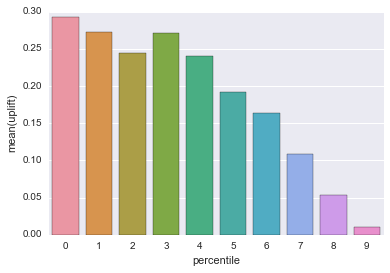

In [167]:
hist_twomod = get_hist_cum(df, "uplift_1","is_target","outcome",p=10)
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

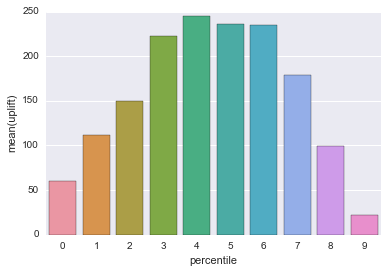

In [168]:
hist_twomod = get_hist_cum_2(df, "uplift_1","is_target","outcome",p=10)
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

We can generalize this idea by calculating this for each point. This would give us an "Uplift Curve"

## Uplift Curve

Idea : 
- Concatenate treatment and control dataset. 
- Order by predicted uplift descending.
- Evaluate sum of uplift for each point.   
That is : uplift value x number of individuals picked (that we'll name t)

Let's denote : 
- RT(t) number of positive outcome and treated  
- RC(t) number of positive outcome and belonging to control
- NT(t) number of treated
- NC(t) number belonging to control

The uplift curve is the curve parametrized by t defined as f(t) = (RT(t)/NT(t) - RC(t)/NC(t)) * NT(t)+NC(t)

Again the uplift evaluation : RT(t)/NT(t) - RC(t)/NC(t) can be found <a href = "https://www.researchgate.net/profile/Guido_Imbens/publication/274644919_Machine_Learning_Methods_for_Estimating_Heterogeneous_Causal_Effects/links/553c02250cf2c415bb0b1720.pdf"> here </a>

In [169]:
def uplift(df, target_control_col, outcome_col, proba_col) :
    tmp = df.copy()
    tmp = tmp.sort(proba_col,ascending=False)
    tmp['RT'] = (tmp[target_control_col]*tmp[outcome_col]).cumsum()
    tmp['RC'] = ((1-tmp[target_control_col])*tmp[outcome_col]).cumsum()
    tmp['NT'] = tmp[target_control_col].cumsum()
    tmp['NC'] = (1-tmp[target_control_col]).cumsum()
    tmp["upc_1"] =   ((tmp['RT']/tmp['NT']).fillna(0) - (tmp['RC']/tmp['NC']).fillna(0)) *(tmp['NC']+tmp['NT'])
    return tmp["upc_1"].values

In [170]:
two_mod_uc = uplift(df,'is_target','outcome','uplift_1')
modified_uc = uplift(df,'is_target','outcome','uplift_2')
perfect_uc = uplift(df,'is_target','outcome','perfect')
rd_uc = (df[df['is_target']==1]['outcome'].sum() / float(df[df['is_target']==1].shape[0])
        - df[df['is_target']==0]['outcome'].sum() / float(df[df['is_target']==0].shape[0]) )
rd = np.arange(df.shape[0]) * rd_uc 

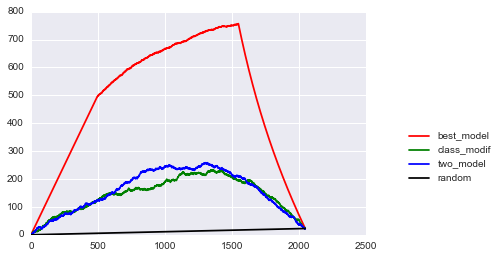

In [171]:
plot(np.arange(df.shape[0]),perfect_uc, color = 'r', label = 'best_model')
plot(np.arange(df.shape[0]),modified_uc, color =  'g', label = 'class_modif')
plot(np.arange(df.shape[0]),two_mod_uc, color = 'b', label = 'two_model')
plot(np.arange(df.shape[0]),rd,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

** Remarks **
- Uplift Curve is a simple generalization of Uplift per decile.
- The better the area under the curve the better -> comparable to AUC
- UC = NC ( NT + NC )  QINI ! (see following evaluation method)  
- the two model approach performs better since it is consistently higher. 
- the best model is not totally well defined. Anything could happen between getting all the positive treated and positive non treated.

## Qini Curves 

For more info on Qini curves, refer to <a href = "http://www.maths.ed.ac.uk/~mthdat25/uplift/dma2006-3-1" >this paper</a>. 

In [172]:
def qini(df, target_control_col, outcome_col, proba_col) : 
    tmp = df.copy()
    tmp = tmp.sort(proba_col,ascending = False)
    tmp['RT'] = (tmp[target_control_col]*tmp[outcome_col]).cumsum()
    tmp['RC'] = ((1-tmp[target_control_col])*tmp[outcome_col]).cumsum()
    tmp['NT'] = tmp[target_control_col].cumsum()
    tmp['NC'] = (1-tmp[target_control_col]).cumsum()
    tmp['second_part'] = (tmp['RC'] * tmp['NT'] / tmp['NC']).fillna(0)
    tmp['qini'] = tmp['RT'] - tmp['second_part'] 
    return tmp['qini']

In [173]:
two_modqini = qini(df,'is_target','outcome','uplift_1')
modified_qini = qini(df,'is_target','outcome','uplift_2')
perfect_qini = qini(df,'is_target','outcome','perfect')
secpart = df[df['is_target']==0]['outcome'].sum() \
    * float(df[df['is_target']==1].shape[0])/df[df['is_target']==0].shape[0]
rqini = df[df['is_target']==1]['outcome'].sum() - secpart
rd = np.arange(len(perfect_qini)) * rqini / len(perfect_qini)

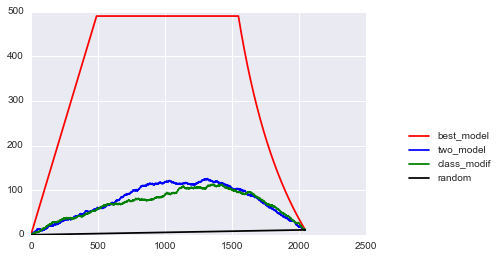

In [174]:
plot(np.arange(df.shape[0]),perfect_qini, color = 'r', label = 'best_model')
plot(np.arange(df.shape[0]),two_modqini, color =  'b', label = 'two_model')
plot(np.arange(df.shape[0]),modified_qini, color = 'g', label = 'class_modif')
plot(np.arange(df.shape[0]),rd,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

** Conclusions ** 
- the theoretical random model (black line) shows that overall, the treatment has a tiny positive effect (positive but low slope) 
- the red curve correspond to the best theoretical model. The closer to the red curve, the better.
- the two model approach seems to perform better than the other approach since its curve is consistently higher. 
- However, there is room for improovement since we are far from the red curve in both cases.  

** Rqs : **
- as in lift, you can select best qini / uplift for X % of the pop.
- same as proba for classif, you can specify a uplift cutoff for people to choose.   
Logical cuttoff is 0 (if action cost 0) = equivalent of 0.5 for classif. 

## Athey Measure 

cf <a href = "https://www.researchgate.net/profile/Guido_Imbens/publication/274644919_Machine_Learning_Methods_for_Estimating_Heterogeneous_Causal_Effects/links/553c02250cf2c415bb0b1720.pdf"> here </a> 

It is based on the fact that :   
E(Yi\*) = tau (with tau the real uplift)   
having Yi\* = Yi . (Wi - e(Xi))/(e(Xi)(1-e(Xi)))

The formula is :  

Q = 1/N Sum(Yi\* - tau)^2  
Q = 1/N (sum(Yt/p - tau)^2 + sum(-Yc/(1-p) - tau)^2)

In [175]:
def Q_Athey(df,target_control_col, outcome_col, proba_col):
    tmp = df.copy()
    p = 1.0/2 # fixed temp here. 
    #estimation of e(Xi) is a pb. need to think about which estimator to put here. 
    # A/B test perfect -> p = 1/2
    tmp['Yi_star'] = tmp[outcome_col] * (tmp[target_control_col]-p)/(p*(1-p)) 
    tmp["delta"] = tmp['Yi_star'] - tmp[proba_col]
    return np.mean(tmp['delta']*tmp['delta'])

- This is the rmse for proba in uplift case (though this measure works also for regression)
- this is close model modification ! 

In [176]:
print Q_Athey(df,'is_target','outcome','uplift_1')
print Q_Athey(df,'is_target','outcome','uplift_2')

1.88434807228
1.89560676296


** ccl **
- unsurprisingly the class modification approach performs better. Since it optimize a loss close to this one. 

# General Metric Conclusion

Like in classification, there are two types of metrics to measure uplift quality : 
- free from any cut off.
- based on a cut off 

For classification that would be : 

- AUC, log loss, rmse
- Accuracy, F1-Score, Lift at a certain %

There is an equivalent for uplift : 
- Qini and Uplift curve are similar to ROC and Lift. 